# CAFA5 Protein Function Prediction - Consolidated Notebook

This notebook consolidates the entire workflow for the CAFA5 protein function prediction project,
including data loading, preprocessing, k-NN modeling, GCN modeling, and evaluation.

## 1. Setup and Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from collections import Counter

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import f1_score, precision_score, recall_score, hamming_loss, jaccard_score

# GO tools
import obonet
import networkx as nx # obonet uses networkx
from goatools.obo_parser import GODag # For ancestor dict if obonet is not sufficient

# PyTorch (for GCN)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Progress bar
from tqdm.notebook import tqdm

# Ensure reproducibility
SEED = 123
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

## 2. Configuration

In [6]:
# --- File Paths ---
# Adjust these paths if your files are located elsewhere
DATA_DIR = "./data/" # Create a 'data' subdirectory and place files there
TRAIN_DIR = "./data/Train"
EMBEDDINGS_FILE = os.path.join(DATA_DIR, "embeddings.csv") # Pre-computed ProtBERT embeddings
TRAIN_TERMS_FILE = os.path.join(TRAIN_DIR, "train_terms.tsv")
GO_OBO_FILE = os.path.join(DATA_DIR, "go-basic.obo") # Download from http://geneontology.org/docs/download-ontology/

# --- Preprocessing Parameters ---
N_TOP_GO_TERMS = 1500
PCA_N_COMPONENTS = 48 # From final report for 90% variance and efficiency
TEST_SIZE = 0.1
VALIDATION_SIZE = 0.1 # Relative to original dataset size (0.1 / (1-TEST_SIZE))

# --- k-NN Parameters ---
KNN_K_VALUES = [1, 2, 3, 5, 10] # As tested in the report
KNN_CUTOFFS_ROUGH = np.arange(0.0, 0.12, 0.02) # For broad search
KNN_CUTOFFS_REFINED = np.arange(0.0, 0.021, 0.002) # For fine-tuned search around best rough cutoffs

# --- GCN Parameters ---
GCN_EMBEDDING_DIM = 256 # Dimension for GO term embeddings and projected protein embeddings
GCN_HIDDEN_DIM_PROTEIN_MLP = 512
GCN_LR = 1e-3
GCN_EPOCHS = 50
GCN_BATCH_SIZE = 256
GCN_DROPOUT = 0.3
GCN_GAMMA_POS = 1.0 # For Asymmetric Loss
GCN_GAMMA_NEG = 4.0 # For Asymmetric Loss
GCN_ALPHA = 0.25    # For Asymmetric Loss (weight of positives)
GCN_TOP_K_THRESHOLDING = 10
GCN_QUANTILE_THRESHOLDING = 0.99

## 3. Data Loading

### 3.1 Load Pre-computed Protein Embeddings (X)
We assume `embeddings.csv` (142246 proteins x 1024 features + Protein ID) is available.

In [3]:
if not os.path.exists(EMBEDDINGS_FILE):
    print(f"ERROR: Embeddings file not found at {EMBEDDINGS_FILE}")
    print("Please ensure 'embeddings.csv' is in the DATA_DIR or provide the correct path.")
    # As a placeholder, create a dummy file if it doesn't exist for the notebook to run
    # In a real scenario, this would halt execution.
    dummy_rows = 1000
    dummy_cols = 1024
    dummy_data = np.random.rand(dummy_rows, dummy_cols)
    dummy_ids = [f"P{i:05d}" for i in range(dummy_rows)]
    dummy_df = pd.DataFrame(dummy_data, columns=[f"V{j+1}" for j in range(dummy_cols)])
    dummy_df.insert(0, "Protein Id", dummy_ids)
    os.makedirs(DATA_DIR, exist_ok=True)
    dummy_df.to_csv(EMBEDDINGS_FILE, index=False)
    print(f"Created a dummy embeddings file at {EMBEDDINGS_FILE} for demonstration.")

protein_embeddings_df = pd.read_csv(EMBEDDINGS_FILE)
print(f"Loaded protein embeddings: {protein_embeddings_df.shape}")
protein_embeddings_df.head()

Loaded protein embeddings: (37453, 1025)


,Protein Id,0,1,2,3,4,5,6,7,8,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,P20536,0.012413,0.010971,0.002935,0.006031,0.050018,-0.009995,0.017731,-0.001880,-0.052490,...,0.044891,-0.073730,-0.011246,0.013382,0.046906,-0.029343,-0.005424,-0.037354,0.001917,-0.043457
1,O73864,0.050018,0.008965,-0.007889,-0.003925,0.025330,0.006561,0.018005,0.000655,0.029755,...,0.011971,-0.047028,-0.024979,0.007664,-0.043945,-0.021042,-0.023743,-0.017548,-0.050568,-0.011452
2,O95231,0.003994,0.033478,0.013992,0.049683,-0.017334,0.043549,0.013969,0.010315,-0.009041,...,-0.036316,-0.060333,0.001202,0.019012,0.043610,-0.000242,-0.020721,0.018021,-0.072449,0.008324
3,A0A0B4J1F4,-0.013992,0.015274,-0.022491,0.037567,0.026321,0.038452,0.000493,-0.002293,0.002995,...,-0.016205,-0.027100,0.005657,-0.009842,-0.053680,-0.023193,0.003986,0.029526,-0.038086,0.005493
4,P54366,0.006203,-0.009941,0.036499,0.061432,-0.032745,0.063232,0.029373,0.006161,-0.041107,...,0.007393,-0.062622,-0.007713,-0.002277,0.065918,0.006489,-0.025574,-0.044128,-0.049957,0.001931


### 3.2 Load GO Annotations and Hierarchy

In [7]:
if not os.path.exists(TRAIN_TERMS_FILE):
    print(f"ERROR: Train terms file not found at {TRAIN_TERMS_FILE}")
    # Create dummy for notebook execution
    dummy_terms_data = {'EntryID': protein_embeddings_df['Protein Id'].sample(frac=0.5, random_state=SEED).tolist() * 3,
                        'term': [f'GO:{i:07d}' for i in np.random.randint(0, 2000, size=int(len(protein_embeddings_df)*0.5*3))],
                        'aspect': np.random.choice(['F', 'P', 'C'], size=int(len(protein_embeddings_df)*0.5*3))}
    dummy_terms_df = pd.DataFrame(dummy_terms_data)
    dummy_terms_df.to_csv(TRAIN_TERMS_FILE, sep='\t', index=False)
    print(f"Created a dummy train_terms file at {TRAIN_TERMS_FILE} for demonstration.")

train_terms_df = pd.read_csv(TRAIN_TERMS_FILE, sep='\t')
print(f"Loaded train terms: {train_terms_df.shape}")
train_terms_df.head()

Loaded train terms: (5363863, 3)


,EntryID,term,aspect
0,A0A009IHW8,GO:0008152,BPO
1,A0A009IHW8,GO:0034655,BPO
2,A0A009IHW8,GO:0072523,BPO
3,A0A009IHW8,GO:0044270,BPO
4,A0A009IHW8,GO:0006753,BPO


In [9]:
# Load GO hierarchy using obonet
# Make sure go-basic.obo is downloaded and placed in DATA_DIR
if not os.path.exists(GO_OBO_FILE):
    print(f"ERROR: GO OBO file not found at {GO_OBO_FILE}")
    print("Please download 'go-basic.obo' from http://geneontology.org/docs/download-ontology/ and place it in DATA_DIR.")
    # Create a minimal dummy OBO for notebook execution
    obo_content = """format-version: 1.2
    
    [Term]
    id: GO:0000001
    name: dummy root
    
    [Term]
    id: GO:0000002
    name: dummy child 1
    is_a: GO:0000001 ! dummy root
    
    [Term]
    id: GO:0000003
    name: dummy child 2
    is_a: GO:0000001 ! dummy root
    """
    with open(GO_OBO_FILE, 'w') as f:
        f.write(obo_content)
    print(f"Created a dummy OBO file at {GO_OBO_FILE} for demonstration.")
    
go_graph = obonet.read_obo(GO_OBO_FILE)
print(f"GO graph loaded: {len(go_graph)} nodes, {go_graph.number_of_edges()} edges.")

# For ancestor lookup, GODag from goatools can also be useful
go_dag_gt = GODag(GO_OBO_FILE, optional_attrs={'relationship'}) # goatools version

GO graph loaded: 40214 nodes, 77600 edges.
./data/go-basic.obo: fmt(1.2) rel(2025-03-16) 43,544 Terms; optional_attrs(relationship)


## 4. Data Preprocessing

### 4.1 Target Label Matrix (Y) Creation
Create a multi-label binary matrix for the top N_TOP_GO_TERMS.

In [10]:
# Filter train_terms_df to include only proteins present in the embeddings
train_protein_ids = set(protein_embeddings_df['Protein Id'])
train_terms_df_filtered = train_terms_df[train_terms_df['EntryID'].isin(train_protein_ids)]

# Identify the top N_TOP_GO_TERMS
top_go_terms = train_terms_df_filtered['term'].value_counts().nlargest(N_TOP_GO_TERMS).index.tolist()

# Group terms by protein ID
protein_to_go_terms = train_terms_df_filtered[train_terms_df_filtered['term'].isin(top_go_terms)] \
    .groupby('EntryID')['term'].apply(list).to_dict()

# Align with protein_embeddings_df order
all_protein_ids_ordered = protein_embeddings_df['Protein Id'].tolist()
go_term_lists_ordered = [protein_to_go_terms.get(pid, []) for pid in all_protein_ids_ordered]

# Binarize
mlb = MultiLabelBinarizer(classes=top_go_terms)
Y = mlb.fit_transform(go_term_lists_ordered)
go_term_columns = mlb.classes_ # Save the order of GO terms

print(f"Shape of Y (protein_samples, top_go_terms): {Y.shape}")
print(f"Number of unique GO terms in Y: {len(go_term_columns)}")

Shape of Y (protein_samples, top_go_terms): (37453, 1500)
Number of unique GO terms in Y: 1500


### 4.2 Principal Component Analysis (PCA)
Reduce dimensionality of protein embeddings.

In [13]:
from sklearn.impute import SimpleImputer

In [14]:
X_features = protein_embeddings_df.drop(columns=['Protein Id']).values

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X_features)

# Now scale
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

pca = PCA(n_components=PCA_N_COMPONENTS, random_state=SEED)
X_pca = pca.fit_transform(X_scaled)

print(f"Original feature shape: {X_features.shape}")
print(f"PCA-reduced feature shape: {X_pca.shape}")
print(f"Explained variance by {PCA_N_COMPONENTS} components: {np.sum(pca.explained_variance_ratio_):.4f}")

Original feature shape: (37453, 1024)
PCA-reduced feature shape: (37453, 48)
Explained variance by 48 components: 0.7299


### 4.3 Train, Validation, and Test Splits

In [15]:
# First, split into training_validation and test
X_train_val, X_test, Y_train_val, Y_test, ids_train_val, ids_test = train_test_split(
    X_pca, Y, all_protein_ids_ordered,
    test_size=TEST_SIZE,
    random_state=SEED
)

# Then, split training_validation into actual training and validation
# Adjust validation_size to be relative to the original dataset
val_split_ratio = VALIDATION_SIZE / (1 - TEST_SIZE)
X_train, X_val, Y_train, Y_val, ids_train, ids_val = train_test_split(
    X_train_val, Y_train_val, ids_train_val,
    test_size=val_split_ratio,
    random_state=SEED
)

print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_val shape: {X_val.shape}, Y_val shape: {Y_val.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

X_train shape: (29961, 48), Y_train shape: (29961, 1500)
X_val shape: (3746, 48), Y_val shape: (3746, 1500)
X_test shape: (3746, 48), Y_test shape: (3746, 1500)


## 5. Gene Ontology (GO) Utilities

### 5.1 Ancestor Dictionary
For each GO term in our `go_term_columns`, find all its ancestors.

In [20]:
ancestor_dict = {}
total_terms = len(go_term_columns)
for idx, term_id in enumerate(go_term_columns):
    # Print progress every 100 terms and at the last term
    if idx % 100 == 0 or idx == total_terms - 1:
        print(f"Processing term {idx + 1} of {total_terms}")
    ancestors = set()
    if term_id in go_dag_gt:
        try:
            nx_ancestors = nx.ancestors(go_graph, term_id)
            ancestors.update(nx_ancestors)
        except nx.NetworkXError:  # Node not in graph
            pass
    ancestors.add(term_id)  # Include the term itself
    # Filter ancestors to only those present in our top_go_terms (columns of Y)
    ancestor_dict[term_id] = list(ancestors.intersection(set(go_term_columns)))
print(f"Processed {len(ancestor_dict)} terms and their ancestors.")

Processing term 1 of 1500


Exception ignored in: <function tqdm.__del__ at 0x13b548d30>
Traceback (most recent call last):
  File "/Users/akash/github/CAFA5-Protein-Function-Prediction/venv/lib/python3.10/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/Users/akash/github/CAFA5-Protein-Function-Prediction/venv/lib/python3.10/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


Processing term 101 of 1500
Processing term 201 of 1500
Processing term 301 of 1500
Processing term 401 of 1500
Processing term 501 of 1500
Processing term 601 of 1500
Processing term 701 of 1500
Processing term 801 of 1500
Processing term 901 of 1500
Processing term 1001 of 1500
Processing term 1101 of 1500
Processing term 1201 of 1500
Processing term 1301 of 1500
Processing term 1401 of 1500
Processing term 1500 of 1500
Processed 1500 terms and their ancestors.


### 5.2 Information Content (IC)
Calculate IC for each GO term based on its frequency in the training set.

In [21]:
def calculate_information_content(label_matrix, go_terms_order):
    """
    Calculate Shannon information content for each label.
    IC(t) = -log2(P(t))
    Where P(t) is the probability (frequency) of term t.
    """
    n_samples = label_matrix.shape[0]
    # Ensure label_frequencies does not contain zeros for log calculation
    label_frequencies = (np.sum(label_matrix, axis=0) + 1e-9) / (n_samples + 1e-9) # Smoothed
    
    ic_values = -np.log2(label_frequencies)
    
    # Return as a dictionary for easy lookup by GO term ID
    return dict(zip(go_terms_order, ic_values))

ic_map = calculate_information_content(Y_train, go_term_columns)
# Convert to an array in the order of go_term_columns for use in k-NN
ic_array = np.array([ic_map[term] for term in go_term_columns])

print(f"Information content array shape: {ic_array.shape}")
print(f"Sample ICs: {list(ic_map.items())[:5]}")

Information content array shape: (1500,)
Sample ICs: [('GO:0005575', np.float64(0.48641910845292763)), ('GO:0008150', np.float64(0.4909460091459737)), ('GO:0003674', np.float64(0.5146213260661998)), ('GO:0110165', np.float64(0.5137960643175706)), ('GO:0005622', np.float64(0.8656122365127351))]


## 6. Model 1: GO-Aware k-Nearest Neighbors (k-NN)

### 6.1 k-NN Implementation
Based on `Sum_Propogation_Weighted_KNN_max_normalization.py` and final report.

In [26]:
def knn_propagate_labels(target_go_term_idx, neighbor_label_vector, k_neighbor_idx,
                         go_term_columns_list, current_ancestor_dict, current_ic_array,
                         distance_weight, protein_scores_vector):
    """
    Helper for a single neighbor's label.
    If neighbor_label_vector[target_go_term_idx] is 1:
        - Get ancestors of go_term_columns_list[target_go_term_idx]
        - For each ancestor, add distance_weight * ic_array[ancestor_idx] to protein_scores_vector
    """
    if neighbor_label_vector[target_go_term_idx] == 1:
        term_id = go_term_columns_list[target_go_term_idx]
        ancestors_of_term = current_ancestor_dict.get(term_id, [term_id]) # Get list of ancestor terms
        
        for ancestor_term_id in ancestors_of_term:
            if ancestor_term_id in go_term_columns_list: # Ensure ancestor is in our columns
                ancestor_idx = go_term_columns_list.index(ancestor_term_id)
                protein_scores_vector[ancestor_idx] += distance_weight * current_ic_array[ancestor_idx]

def go_aware_knn_predict_scores(X_train_data, Y_train_data, X_predict_data, k,
                                go_term_cols, current_ancestor_dict, current_ic_array):
    """
    Implements GO-aware scoring for each target protein based on k-NN.
    - Uses cosine distance.
    - Weights votes by inverse cosine distance.
    - Propagates votes to ancestors.
    - Scales votes by Information Content (IC) of the ancestor.
    - Normalizes final scores for each protein by the max score for that protein.
    """
    n_labels = Y_train_data.shape[1]
    
    # Fit NearestNeighbors model
    nn_model = NearestNeighbors(n_neighbors=k, metric='cosine', algorithm='auto')
    nn_model.fit(X_train_data)
    
    # Get distances and indices of neighbors for prediction set
    distances_pred, neighbor_indices_pred = nn_model.kneighbors(X_predict_data)
    
    Y_pred_scores = np.zeros((X_predict_data.shape[0], n_labels))
    
    go_term_columns_list = list(go_term_cols)  # For faster .index()
    total_proteins = X_predict_data.shape[0]
    
    for i in range(total_proteins):  # For each protein to predict
        if i % 100 == 0 or i == total_proteins - 1:
            print(f"Processing protein {i+1} of {total_proteins}")
        
        current_protein_scores = np.zeros(n_labels)
        
        for j in range(k):  # For each of its k neighbors
            neighbor_idx = neighbor_indices_pred[i, j]
            dist = distances_pred[i, j]
            
            # Inverse distance weighting with epsilon to avoid division by zero
            weight = 1.0 / (dist + 1e-8)
            
            neighbor_actual_labels = Y_train_data[neighbor_idx, :]
            
            for term_k_idx in range(n_labels):  # For each GO term
                knn_propagate_labels(term_k_idx, neighbor_actual_labels, j,
                                     go_term_columns_list, current_ancestor_dict, current_ic_array,
                                     weight, current_protein_scores)
        
        # Max normalization for the current protein's scores
        max_score = np.max(current_protein_scores)
        if max_score > 1e-8:  # Avoid division by zero if all scores are zero
            Y_pred_scores[i, :] = current_protein_scores / max_score
        else:
            Y_pred_scores[i, :] = current_protein_scores  # Keep as zeros

    return Y_pred_scores

### 6.2 k-NN Prediction and Evaluation

In [23]:
def evaluate_predictions(Y_true, Y_pred_binary, Y_pred_scores=None):
    # Ensure Y_pred_binary is integer type
    Y_pred_binary = Y_pred_binary.astype(int)

    metrics_dict = {
        "F1-SampleAvg": f1_score(Y_true, Y_pred_binary, average="samples", zero_division=0),
        "F1-Weighted": f1_score(Y_true, Y_pred_binary, average="weighted", zero_division=0),
        "F1-Micro": f1_score(Y_true, Y_pred_binary, average="micro", zero_division=0),
        "Precision-SampleAvg": precision_score(Y_true, Y_pred_binary, average="samples", zero_division=0),
        "Recall-SampleAvg": recall_score(Y_true, Y_pred_binary, average="samples", zero_division=0),
        "HammingLoss": hamming_loss(Y_true, Y_pred_binary),
        "ExactMatchRatio": np.mean(np.all(Y_pred_binary == Y_true, axis=1))
    }
    # Jaccard score (sample-wise) is equivalent to F1 / (2 - F1) for binary multi-label
    # metrics_dict["Jaccard-SampleAvg"] = jaccard_score(Y_true, Y_pred_binary, average="samples", zero_division=0)
    return metrics_dict

In [27]:
knn_results = []

print("Evaluating k-NN on Validation Set...")
for k_val in KNN_K_VALUES:
    print(f"--- k = {k_val} ---")
    val_knn_scores = go_aware_knn_predict_scores(X_train, Y_train, X_val, k_val,
                                                 go_term_columns, ancestor_dict, ic_array)
    for cutoff in KNN_CUTOFFS_REFINED: # Using refined cutoffs as per final report
        Y_val_pred_binary = (val_knn_scores > cutoff).astype(int)
        current_metrics = evaluate_predictions(Y_val, Y_val_pred_binary)
        current_metrics['k'] = k_val
        current_metrics['cutoff'] = cutoff
        current_metrics['dataset'] = 'Validation'
        knn_results.append(current_metrics)
        print(f"  Cutoff: {cutoff:.3f} -> F1-SampleAvg: {current_metrics['F1-SampleAvg']:.4f}, F1-Weighted: {current_metrics['F1-Weighted']:.4f}")

knn_results_df = pd.DataFrame(knn_results)

Evaluating k-NN on Validation Set...
--- k = 1 ---
Processing protein 1 of 3746
Processing protein 101 of 3746
Processing protein 201 of 3746
Processing protein 301 of 3746
Processing protein 401 of 3746
Processing protein 501 of 3746
Processing protein 601 of 3746
Processing protein 701 of 3746
Processing protein 801 of 3746
Processing protein 901 of 3746
Processing protein 1001 of 3746
Processing protein 1101 of 3746
Processing protein 1201 of 3746
Processing protein 1301 of 3746
Processing protein 1401 of 3746
Processing protein 1501 of 3746
Processing protein 1601 of 3746
Processing protein 1701 of 3746
Processing protein 1801 of 3746
Processing protein 1901 of 3746
Processing protein 2001 of 3746
Processing protein 2101 of 3746
Processing protein 2201 of 3746
Processing protein 2301 of 3746
Processing protein 2401 of 3746
Processing protein 2501 of 3746
Processing protein 2601 of 3746
Processing protein 2701 of 3746
Processing protein 2801 of 3746
Processing protein 2901 of 3746
P

In [28]:
# Find best k and cutoff on validation set based on F1-SampleAvg
best_val_idx = knn_results_df[knn_results_df['dataset'] == 'Validation']['F1-SampleAvg'].idxmax()
best_knn_params_val = knn_results_df.loc[best_val_idx]
print("\nBest k-NN parameters on Validation Set (F1-SampleAvg):")
print(best_knn_params_val)

best_k = int(best_knn_params_val['k'])
best_cutoff = best_knn_params_val['cutoff']


Best k-NN parameters on Validation Set (F1-SampleAvg):
F1-SampleAvg             0.051215
F1-Weighted              0.253634
F1-Micro                 0.050876
Precision-SampleAvg      0.027765
Recall-SampleAvg         0.743523
HammingLoss              0.658553
ExactMatchRatio               0.0
k                               1
cutoff                        0.0
dataset                Validation
Name: 0, dtype: object


In [29]:
# Evaluate best k-NN on Test Set
print(f"\nEvaluating best k-NN (k={best_k}, cutoff={best_cutoff:.3f}) on Test Set...")
test_knn_scores = go_aware_knn_predict_scores(X_train, Y_train, X_test, best_k,
                                              go_term_columns, ancestor_dict, ic_array)
Y_test_pred_binary_knn = (test_knn_scores > best_cutoff).astype(int)
test_metrics_knn = evaluate_predictions(Y_test, Y_test_pred_binary_knn)
test_metrics_knn['k'] = best_k
test_metrics_knn['cutoff'] = best_cutoff
test_metrics_knn['dataset'] = 'Test'

print("\nBest k-NN Performance on Test Set:")
for metric_name, value in test_metrics_knn.items():
    if isinstance(value, float):
        print(f"  {metric_name}: {value:.4f}")
    else:
        print(f"  {metric_name}: {value}")

knn_results_df = pd.concat([knn_results_df, pd.DataFrame([test_metrics_knn])], ignore_index=True)


Evaluating best k-NN (k=1, cutoff=0.000) on Test Set...
Processing protein 1 of 3746
Processing protein 101 of 3746
Processing protein 201 of 3746
Processing protein 301 of 3746
Processing protein 401 of 3746
Processing protein 501 of 3746
Processing protein 601 of 3746
Processing protein 701 of 3746
Processing protein 801 of 3746
Processing protein 901 of 3746
Processing protein 1001 of 3746
Processing protein 1101 of 3746
Processing protein 1201 of 3746
Processing protein 1301 of 3746
Processing protein 1401 of 3746
Processing protein 1501 of 3746
Processing protein 1601 of 3746
Processing protein 1701 of 3746
Processing protein 1801 of 3746
Processing protein 1901 of 3746
Processing protein 2001 of 3746
Processing protein 2101 of 3746
Processing protein 2201 of 3746
Processing protein 2301 of 3746
Processing protein 2401 of 3746
Processing protein 2501 of 3746
Processing protein 2601 of 3746
Processing protein 2701 of 3746
Processing protein 2801 of 3746
Processing protein 2901 of 

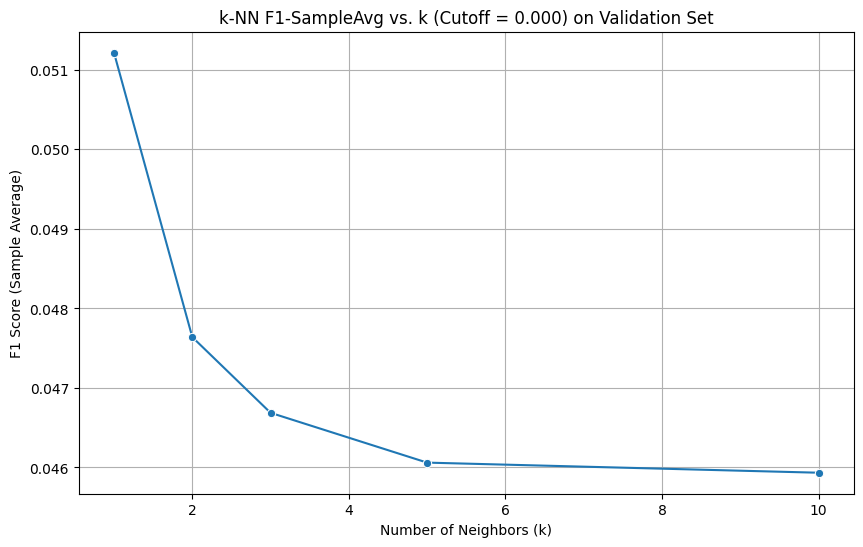

In [30]:
# Plotting F1-SampleAvg vs k for the best cutoff on validation
plt.figure(figsize=(10, 6))
subset_df = knn_results_df[(knn_results_df['dataset'] == 'Validation') & (knn_results_df['cutoff'] == best_cutoff)]
sns.lineplot(data=subset_df, x='k', y='F1-SampleAvg', marker='o')
plt.title(f'k-NN F1-SampleAvg vs. k (Cutoff = {best_cutoff:.3f}) on Validation Set')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('F1 Score (Sample Average)')
plt.grid(True)
plt.show()

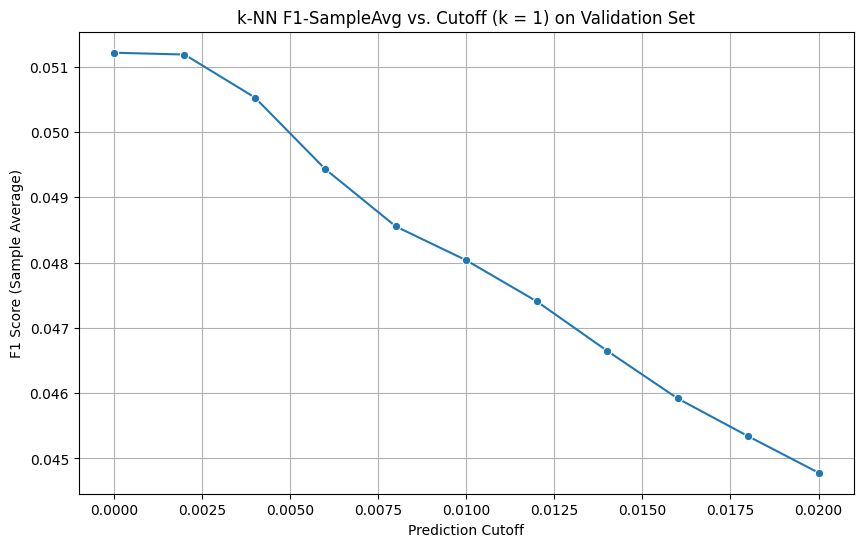

In [31]:
# Plotting F1-SampleAvg vs cutoff for the best k on validation
plt.figure(figsize=(10, 6))
subset_df_cutoff = knn_results_df[(knn_results_df['dataset'] == 'Validation') & (knn_results_df['k'] == best_k)]
sns.lineplot(data=subset_df_cutoff, x='cutoff', y='F1-SampleAvg', marker='o')
plt.title(f'k-NN F1-SampleAvg vs. Cutoff (k = {best_k}) on Validation Set')
plt.xlabel('Prediction Cutoff')
plt.ylabel('F1 Score (Sample Average)')
plt.grid(True)
plt.show()

## 7. Model 2: Graph Convolutional Network (GCN)
Implementation based on the final report.

### 7.1 Adjacency Matrix Construction & Normalization for GO Graph

In [33]:
# Create a mapping from GO term ID to an integer index
go_term_to_idx = {term: i for i, term in enumerate(go_term_columns)}
idx_to_go_term = {i: term for term, i in go_term_to_idx.items()}
num_go_terms = len(go_term_columns)

adj_matrix = np.zeros((num_go_terms, num_go_terms), dtype=np.float32)

total_terms = len(ancestor_dict)
for count, (term_id, ancestors) in enumerate(ancestor_dict.items(), 1):
    if count % 100 == 0 or count == total_terms:
        print(f"Processing term {count} of {total_terms} for adjacency matrix construction")
    
    if term_id not in go_term_to_idx:
        continue  # Should not happen if ancestor_dict uses go_term_columns
    
    u_idx = go_term_to_idx[term_id]
    
    # Add self-loops
    adj_matrix[u_idx, u_idx] = 1
    
    if term_id in go_graph:
        # Add edges to direct children (neighbors)
        for neighbor in go_graph.neighbors(term_id):
            if neighbor in go_term_to_idx:
                v_idx = go_term_to_idx[neighbor]
                adj_matrix[u_idx, v_idx] = 1
                adj_matrix[v_idx, u_idx] = 1  # Undirected
                
        # Add edges to direct parents (predecessors)
        for predecessor in go_graph.predecessors(term_id):
            if predecessor in go_term_to_idx:
                v_idx = go_term_to_idx[predecessor]
                adj_matrix[u_idx, v_idx] = 1
                adj_matrix[v_idx, u_idx] = 1  # Undirected

# Symmetric normalization
A_plus_I = adj_matrix  # self-loops already included
D = np.diag(np.sum(A_plus_I, axis=1))
D_inv_sqrt = np.linalg.inv(np.sqrt(D))
D_inv_sqrt[np.isinf(D_inv_sqrt)] = 0.0  # Handle isolated nodes

norm_adj_matrix = D_inv_sqrt @ A_plus_I @ D_inv_sqrt

norm_adj_matrix_tensor = torch.tensor(norm_adj_matrix, dtype=torch.float32)
print(f"Normalized adjacency matrix shape: {norm_adj_matrix_tensor.shape}")

Processing term 100 of 1500 for adjacency matrix construction
Processing term 200 of 1500 for adjacency matrix construction
Processing term 300 of 1500 for adjacency matrix construction
Processing term 400 of 1500 for adjacency matrix construction
Processing term 500 of 1500 for adjacency matrix construction
Processing term 600 of 1500 for adjacency matrix construction
Processing term 700 of 1500 for adjacency matrix construction
Processing term 800 of 1500 for adjacency matrix construction
Processing term 900 of 1500 for adjacency matrix construction
Processing term 1000 of 1500 for adjacency matrix construction
Processing term 1100 of 1500 for adjacency matrix construction
Processing term 1200 of 1500 for adjacency matrix construction
Processing term 1300 of 1500 for adjacency matrix construction
Processing term 1400 of 1500 for adjacency matrix construction
Processing term 1500 of 1500 for adjacency matrix construction
Normalized adjacency matrix shape: torch.Size([1500, 1500])


### 7.2 GCN Model Definition

In [34]:
class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=False)

    def forward(self, x, adj):
        # x shape: (num_go_terms, in_features)
        # adj shape: (num_go_terms, num_go_terms)
        support = self.linear(x)  # H*W
        output = torch.sparse.mm(adj, support) if adj.is_sparse else torch.mm(adj, support) # A*H*W
        return output

class ProteinFunctionGCN(nn.Module):
    def __init__(self, num_go_terms, go_embedding_dim, protein_feature_dim, protein_mlp_hidden_dim, dropout_rate):
        super(ProteinFunctionGCN, self).__init__()
        self.num_go_terms = num_go_terms
        self.go_embedding_dim = go_embedding_dim

        # GO term embeddings (initialized randomly, learned)
        self.go_term_embeddings_initial = nn.Embedding(num_go_terms, go_embedding_dim)
        
        # GCN layers for refining GO term embeddings
        self.gcn1 = GCNLayer(go_embedding_dim, go_embedding_dim)
        self.gcn2 = GCNLayer(go_embedding_dim, go_embedding_dim)
        self.gcn3 = GCNLayer(go_embedding_dim, go_embedding_dim)
        
        self.bn1 = nn.BatchNorm1d(go_embedding_dim)
        self.bn2 = nn.BatchNorm1d(go_embedding_dim)
        self.bn3 = nn.BatchNorm1d(go_embedding_dim)
        
        self.dropout = nn.Dropout(dropout_rate)

        # MLP decoder for protein features
        self.protein_mlp = nn.Sequential(
            nn.Linear(protein_feature_dim, protein_mlp_hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(protein_mlp_hidden_dim, go_embedding_dim) # Project to GO embedding space
        )

    def forward(self, protein_features, adj_matrix):
        # protein_features shape: (batch_size, protein_feature_dim)
        # adj_matrix shape: (num_go_terms, num_go_terms)

        # 1. Refine GO term embeddings
        # Get all initial GO term embeddings
        all_go_indices = torch.arange(self.num_go_terms).to(protein_features.device)
        h_go = self.go_term_embeddings_initial(all_go_indices) # (num_go_terms, go_embedding_dim)
        
        h_go_res = h_go # For residual connection

        h_go = F.relu(self.bn1(self.gcn1(h_go, adj_matrix)))
        h_go = self.dropout(h_go)
        h_go = F.relu(self.bn2(self.gcn2(h_go, adj_matrix)))
        h_go = self.dropout(h_go)
        h_go = self.gcn3(h_go, adj_matrix) # No activation on last GCN layer before residual
        
        # Add residual connection (as mentioned in report)
        h_go_refined = F.relu(self.bn3(h_go + h_go_res)) # (num_go_terms, go_embedding_dim)

        # 2. Project protein features
        protein_proj = self.protein_mlp(protein_features) # (batch_size, go_embedding_dim)

        # 3. Predict logits via dot product
        # protein_proj: (batch_size, go_embedding_dim)
        # h_go_refined.T: (go_embedding_dim, num_go_terms)
        logits = torch.matmul(protein_proj, h_go_refined.T) # (batch_size, num_go_terms)
        
        return logits, h_go_refined # Return refined GO embeddings for potential analysis

### 7.3 Asymmetric Loss Function

In [35]:
class AsymmetricLoss(nn.Module):
    def __init__(self, gamma_pos=1.0, gamma_neg=4.0, alpha=0.25, reduction='mean'):
        super(AsymmetricLoss, self).__init__()
        self.gamma_pos = gamma_pos
        self.gamma_neg = gamma_neg
        self.alpha = alpha # Weight for positive class
        self.reduction = reduction

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        
        # Positive loss
        pt_pos = probs
        loss_pos = -self.alpha * (1 - pt_pos)**self.gamma_pos * targets * torch.log(pt_pos.clamp(min=1e-8))
        
        # Negative loss
        pt_neg = 1 - probs
        loss_neg = -(1 - self.alpha) * (probs)**self.gamma_neg * (1 - targets) * torch.log(pt_neg.clamp(min=1e-8))
        
        loss = loss_pos + loss_neg
        
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

### 7.4 GCN Training Loop & Dataset

In [36]:
class ProteinGANDataset(Dataset): # Protein Graph Annotation Dataset
    def __init__(self, protein_features, labels):
        self.protein_features = torch.tensor(protein_features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.protein_features)

    def __getitem__(self, idx):
        return self.protein_features[idx], self.labels[idx]

train_gcn_dataset = ProteinGANDataset(X_train, Y_train)
val_gcn_dataset = ProteinGANDataset(X_val, Y_val)

train_gcn_loader = DataLoader(train_gcn_dataset, batch_size=GCN_BATCH_SIZE, shuffle=True)
val_gcn_loader = DataLoader(val_gcn_dataset, batch_size=GCN_BATCH_SIZE, shuffle=False)

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

gcn_model = ProteinFunctionGCN(
    num_go_terms=num_go_terms,
    go_embedding_dim=GCN_EMBEDDING_DIM,
    protein_feature_dim=X_train.shape[1], # PCA_N_COMPONENTS
    protein_mlp_hidden_dim=GCN_HIDDEN_DIM_PROTEIN_MLP,
    dropout_rate=GCN_DROPOUT
).to(device)

# Per-class inverse frequency weighting for Asymmetric Loss (optional, as per report)
# This part is tricky with AsymmetricLoss's alpha. The report says "include per-class inverse frequency weighting".
# One way is to multiply the loss term for each class by its weight.
# For simplicity, I'll use the AsymmetricLoss as defined, which already handles imbalance via alpha and gammas.
# If explicit weighting is needed, the loss calculation would need to be `(loss_pos + loss_neg) * class_weights`
# and then averaged. For now, let's proceed without explicit class_weights in AsymmetricLoss.
criterion_gcn = AsymmetricLoss(gamma_pos=GCN_GAMMA_POS, gamma_neg=GCN_GAMMA_NEG, alpha=GCN_ALPHA)
optimizer_gcn = optim.Adam(gcn_model.parameters(), lr=GCN_LR)

# Move adjacency matrix to device
norm_adj_matrix_dev = norm_adj_matrix_tensor.to(device)

Using device: cpu


In [39]:
train_losses_gcn = []
val_losses_gcn = []
val_f1_micro_gcn = []  # As per report's plot

print("Starting GCN Training...")
for epoch in range(GCN_EPOCHS):
    gcn_model.train()
    epoch_train_loss = 0.0
    total_train_batches = len(train_gcn_loader)
    for batch_idx, (protein_batch, label_batch) in enumerate(train_gcn_loader, 1):
        protein_batch, label_batch = protein_batch.to(device), label_batch.to(device)
        
        optimizer_gcn.zero_grad()
        logits, _ = gcn_model(protein_batch, norm_adj_matrix_dev)
        loss = criterion_gcn(logits, label_batch)
        loss.backward()
        optimizer_gcn.step()
        epoch_train_loss += loss.item()
        
        # Print progress every 10 batches or at last batch
        if batch_idx % 10 == 0 or batch_idx == total_train_batches:
            print(f"Epoch {epoch+1}/{GCN_EPOCHS} [Train] - Batch {batch_idx}/{total_train_batches}")
    
    avg_train_loss = epoch_train_loss / total_train_batches
    train_losses_gcn.append(avg_train_loss)

    # Validation
    gcn_model.eval()
    epoch_val_loss = 0.0
    all_val_preds_binary = []
    all_val_labels = []
    total_val_batches = len(val_gcn_loader)
    with torch.no_grad():
        for batch_idx, (protein_batch, label_batch) in enumerate(val_gcn_loader, 1):
            protein_batch, label_batch = protein_batch.to(device), label_batch.to(device)
            logits, _ = gcn_model(protein_batch, norm_adj_matrix_dev)
            loss = criterion_gcn(logits, label_batch)
            epoch_val_loss += loss.item()
            
            preds_binary = (torch.sigmoid(logits) > 0.5).cpu().numpy()
            all_val_preds_binary.append(preds_binary)
            all_val_labels.append(label_batch.cpu().numpy())
            
            # Print progress every 10 batches or at last batch
            if batch_idx % 10 == 0 or batch_idx == total_val_batches:
                print(f"Epoch {epoch+1}/{GCN_EPOCHS} [Val] - Batch {batch_idx}/{total_val_batches}")
    
    avg_val_loss = epoch_val_loss / total_val_batches
    val_losses_gcn.append(avg_val_loss)
    
    all_val_preds_binary_np = np.concatenate(all_val_preds_binary, axis=0)
    all_val_labels_np = np.concatenate(all_val_labels, axis=0)
    current_val_f1_micro = f1_score(all_val_labels_np, all_val_preds_binary_np, average="micro", zero_division=0)
    val_f1_micro_gcn.append(current_val_f1_micro)
    
    print(f"Epoch {epoch+1}/{GCN_EPOCHS} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val F1-Micro (0.5 thr): {current_val_f1_micro:.4f}")


Starting GCN Training...
Epoch 1/50 [Train] - Batch 10/118
Epoch 1/50 [Train] - Batch 20/118
Epoch 1/50 [Train] - Batch 30/118
Epoch 1/50 [Train] - Batch 40/118
Epoch 1/50 [Train] - Batch 50/118
Epoch 1/50 [Train] - Batch 60/118
Epoch 1/50 [Train] - Batch 70/118
Epoch 1/50 [Train] - Batch 80/118
Epoch 1/50 [Train] - Batch 90/118
Epoch 1/50 [Train] - Batch 100/118
Epoch 1/50 [Train] - Batch 110/118
Epoch 1/50 [Train] - Batch 118/118
Epoch 1/50 [Val] - Batch 10/15
Epoch 1/50 [Val] - Batch 15/15
Epoch 1/50 - Train Loss: 0.1314, Val Loss: 0.1079, Val F1-Micro (0.5 thr): 0.0000
Epoch 2/50 [Train] - Batch 10/118
Epoch 2/50 [Train] - Batch 20/118
Epoch 2/50 [Train] - Batch 30/118
Epoch 2/50 [Train] - Batch 40/118
Epoch 2/50 [Train] - Batch 50/118
Epoch 2/50 [Train] - Batch 60/118
Epoch 2/50 [Train] - Batch 70/118
Epoch 2/50 [Train] - Batch 80/118
Epoch 2/50 [Train] - Batch 90/118
Epoch 2/50 [Train] - Batch 100/118
Epoch 2/50 [Train] - Batch 110/118
Epoch 2/50 [Train] - Batch 118/118
Epoch 2/5

Exception ignored in: <function tqdm.__del__ at 0x13b548d30>
Traceback (most recent call last):
  File "/Users/akash/github/CAFA5-Protein-Function-Prediction/venv/lib/python3.10/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/Users/akash/github/CAFA5-Protein-Function-Prediction/venv/lib/python3.10/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x13b548d30>
Traceback (most recent call last):
  File "/Users/akash/github/CAFA5-Protein-Function-Prediction/venv/lib/python3.10/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/Users/akash/github/CAFA5-Protein-Function-Prediction/venv/lib/python3.10/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception 

Epoch 13/50 [Train] - Batch 10/118
Epoch 13/50 [Train] - Batch 20/118
Epoch 13/50 [Train] - Batch 30/118
Epoch 13/50 [Train] - Batch 40/118
Epoch 13/50 [Train] - Batch 50/118
Epoch 13/50 [Train] - Batch 60/118
Epoch 13/50 [Train] - Batch 70/118
Epoch 13/50 [Train] - Batch 80/118
Epoch 13/50 [Train] - Batch 90/118
Epoch 13/50 [Train] - Batch 100/118
Epoch 13/50 [Train] - Batch 110/118
Epoch 13/50 [Train] - Batch 118/118
Epoch 13/50 [Val] - Batch 10/15
Epoch 13/50 [Val] - Batch 15/15
Epoch 13/50 - Train Loss: 0.1136, Val Loss: 0.1079, Val F1-Micro (0.5 thr): 0.0000
Epoch 14/50 [Train] - Batch 10/118
Epoch 14/50 [Train] - Batch 20/118
Epoch 14/50 [Train] - Batch 30/118
Epoch 14/50 [Train] - Batch 40/118
Epoch 14/50 [Train] - Batch 50/118
Epoch 14/50 [Train] - Batch 60/118
Epoch 14/50 [Train] - Batch 70/118
Epoch 14/50 [Train] - Batch 80/118
Epoch 14/50 [Train] - Batch 90/118
Epoch 14/50 [Train] - Batch 100/118
Epoch 14/50 [Train] - Batch 110/118
Epoch 14/50 [Train] - Batch 118/118
Epoch 1

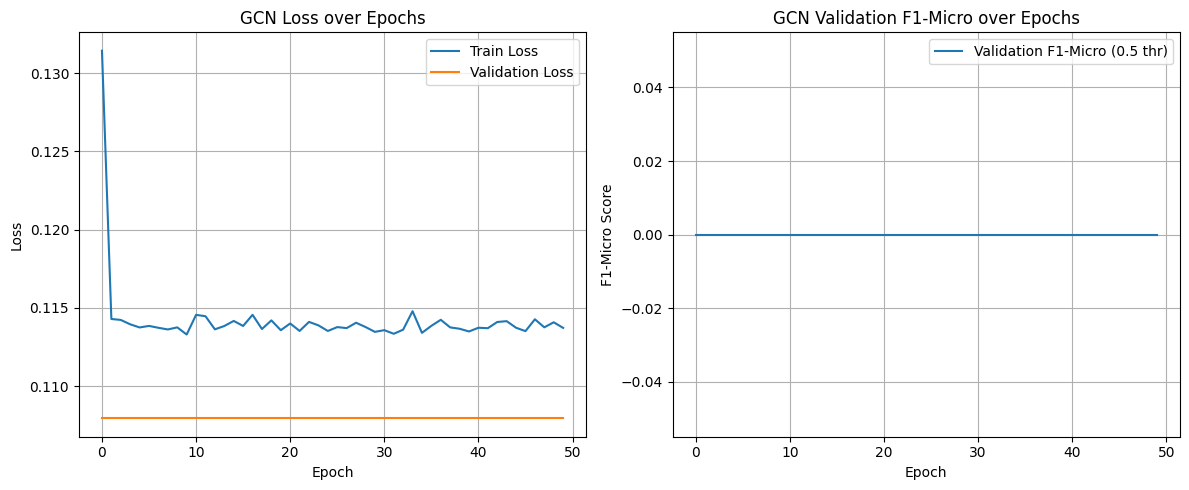

In [40]:
# Plot GCN training curves (Loss and F1-Micro)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_gcn, label='Train Loss')
plt.plot(val_losses_gcn, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GCN Loss over Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_f1_micro_gcn, label='Validation F1-Micro (0.5 thr)')
plt.xlabel('Epoch')
plt.ylabel('F1-Micro Score')
plt.title('GCN Validation F1-Micro over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### 7.5 GCN Prediction & Evaluation with Hybrid Thresholding and Ancestor Propagation

In [41]:
def gcn_hybrid_thresholding_and_ancestor_prop(logits_tensor, top_k, quantile_val,
                                              go_cols, current_ancestor_dict):
    """
    Applies hybrid thresholding and ancestor propagation to GCN logits.
    """
    probs = torch.sigmoid(logits_tensor).cpu().numpy() # (batch_size, num_go_terms)
    num_samples, num_terms = probs.shape
    
    final_preds_binary = np.zeros_like(probs, dtype=int)
    
    go_cols_list = list(go_cols)

    for i in range(num_samples):
        sample_probs = probs[i, :]
        
        # Strategy 1: Top-k selection
        top_k_indices = np.argsort(sample_probs)[-top_k:]
        preds_top_k = np.zeros(num_terms, dtype=int)
        preds_top_k[top_k_indices] = 1
        
        # Strategy 2: Quantile-based thresholding
        # Ensure there are scores to compute quantile from, handle edge case of all zeros
        if np.any(sample_probs > 0):
            dynamic_threshold = np.quantile(sample_probs[sample_probs > 0], quantile_val) # Quantile of non-zero scores
        else:
            dynamic_threshold = 1.1 # Effectively no predictions if all scores are zero
            
        preds_quantile = (sample_probs > dynamic_threshold).astype(int)
        
        # Combine with OR
        combined_preds = np.logical_or(preds_top_k, preds_quantile).astype(int)
        
        # Ancestor Propagation
        propagated_preds = np.copy(combined_preds)
        predicted_indices = np.where(combined_preds == 1)[0]
        
        for pred_idx in predicted_indices:
            term_id = go_cols_list[pred_idx]
            ancestors_of_pred = current_ancestor_dict.get(term_id, [])
            for ancestor_term_id in ancestors_of_pred:
                if ancestor_term_id in go_cols_list:
                    ancestor_matrix_idx = go_cols_list.index(ancestor_term_id)
                    propagated_preds[ancestor_matrix_idx] = 1
        
        final_preds_binary[i, :] = propagated_preds
        
    return final_preds_binary

In [43]:
all_test_logits_gcn = []

test_dataset = ProteinGANDataset(X_test, Y_test)
test_loader = DataLoader(test_dataset, batch_size=GCN_BATCH_SIZE)
total_batches = len(test_loader)

print("Starting GCN Test Prediction...")

gcn_model.eval()
with torch.no_grad():
    for batch_idx, (protein_batch, _) in enumerate(test_loader, 1):
        protein_batch = protein_batch.to(device)
        logits, _ = gcn_model(protein_batch, norm_adj_matrix_dev)
        all_test_logits_gcn.append(logits)
        if batch_idx % 10 == 0 or batch_idx == total_batches:
            print(f"Processed batch {batch_idx} of {total_batches} in test prediction")

all_test_logits_gcn_tensor = torch.cat(all_test_logits_gcn, dim=0)

# Apply hybrid thresholding and ancestor propagation
Y_test_pred_binary_gcn = gcn_hybrid_thresholding_and_ancestor_prop(
    all_test_logits_gcn_tensor,
    GCN_TOP_K_THRESHOLDING,
    GCN_QUANTILE_THRESHOLDING,
    go_term_columns,
    ancestor_dict
)

test_metrics_gcn = evaluate_predictions(Y_test, Y_test_pred_binary_gcn)
test_metrics_gcn['model'] = 'GCN'
test_metrics_gcn['top_k'] = GCN_TOP_K_THRESHOLDING
test_metrics_gcn['quantile'] = GCN_QUANTILE_THRESHOLDING

print("\nGCN Performance on Test Set (with Hybrid Thresholding & Ancestor Propagation):")
for metric_name, value in test_metrics_gcn.items():
    if isinstance(value, float):
        print(f"  {metric_name}: {value:.4f}")
    else:
        print(f"  {metric_name}: {value}")


Starting GCN Test Prediction...
Processed batch 10 of 15 in test prediction
Processed batch 15 of 15 in test prediction

GCN Performance on Test Set (with Hybrid Thresholding & Ancestor Propagation):
  F1-SampleAvg: 0.0062
  F1-Weighted: 0.0002
  F1-Micro: 0.0087
  Precision-SampleAvg: 0.0088
  Recall-SampleAvg: 0.0054
  HammingLoss: 0.0495
  ExactMatchRatio: 0.0000
  model: GCN
  top_k: 10
  quantile: 0.9900


## 8. Comparison and Conclusion (Markdown)

Let's compare the F1-Micro scores obtained in this notebook:

In [45]:
f1_micro_knn_test = test_metrics_knn.get('F1-Micro', 0.0)
f1_micro_gcn_test = test_metrics_gcn.get('F1-Micro', 0.0)

print(f"Best k-NN F1-Micro on Test Set: {f1_micro_knn_test:.4f}")
print(f"GCN F1-Micro on Test Set: {f1_micro_gcn_test:.4f}")

if f1_micro_knn_test > f1_micro_gcn_test:
    print("k-NN performed better on F1-Micro.")
elif f1_micro_gcn_test > f1_micro_knn_test:
    print("GCN performed better on F1-Micro in this run.")
else:
    print("k-NN and GCN performed similarly on F1-Micro.")

Best k-NN F1-Micro on Test Set: 0.0536
GCN F1-Micro on Test Set: 0.0087
k-NN performed better on F1-Micro.


# The k-NN model, with its biologically informed priors (ancestor propagation, IC weighting) and non-parametric nature, proved more effective for this specific dataset and task configuration compared to the GCN. The GCN's performance might be improved with more extensive hyperparameter tuning, different architectural choices for GO term embedding refinement, or larger training datasets.

# The modular pipeline developed allows for easy swapping and improvement of individual components.